In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv  # hack for vs code jupyter extension

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Data.db_connection import get_connection

In [3]:
_ = load_dotenv("/mnt/HDD/Ivan/projects/FantasyPrediction/.envrc", override=True)

In [4]:
## Raw data gathering
player_data_sql = """
select 
	bs.*,
	tgl."PLUS_MINUS" as "team_plus_minus", 
	tgl."PLUS_MINUS_RANK"  as team_plus_minus_rank,
	tgl."W_PCT_RANK" as team_w_pct_rank,
	tgl."PTS" as team_points
from (select 
	"PLAYER_NAME", "TEAM_ID", "GAME_ID", "MIN", "FGM", "FG_PCT", "FG3M", "FTM", "FT_PCT", "PTS", "AST" , "STL" , "DREB", "OREB", "BLK", "PLUS_MINUS", "NBA_FANTASY_PTS" 
	from nba.box_score) as bs
inner join nba.team_game_logs tgl on bs."GAME_ID" = tgl."GAME_ID" ;
"""
df = pd.read_sql(player_data_sql, con=get_connection())
df.head()

,PLAYER_NAME,TEAM_ID,GAME_ID,MIN,FGM,FG_PCT,FG3M,FTM,FT_PCT,PTS,...,STL,DREB,OREB,BLK,PLUS_MINUS,NBA_FANTASY_PTS,team_plus_minus,team_plus_minus_rank,team_w_pct_rank,team_points
0,Zydrunas Ilgauskas,1610612739,20900001,24.643333,1,0.250,0,4,1.0,6,...,0,4,1,0,-2,12.0,-6.0,72,62,89
1,Jamario Moon,1610612739,20900001,13.675000,1,0.333,0,0,0.0,2,...,0,2,0,1,-9,6.4,-6.0,72,62,89
2,Shaquille O'Neal,1610612739,20900001,28.801667,5,0.455,0,0,0.0,10,...,0,10,0,1,2,25.5,-6.0,72,62,89
3,Eddie House,1610612738,20900001,12.496667,1,0.333,1,0,0.0,3,...,0,1,0,1,6,9.2,-6.0,72,62,89
4,Daniel Gibson,1610612739,20900001,13.705000,1,0.333,0,0,0.0,2,...,0,1,0,0,-4,2.2,-6.0,72,62,89


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699770 entries, 0 to 699769
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PLAYER_NAME           699770 non-null  object 
 1   TEAM_ID               699770 non-null  int64  
 2   GAME_ID               699770 non-null  int64  
 3   MIN                   699770 non-null  float64
 4   FGM                   699770 non-null  int64  
 5   FG_PCT                699770 non-null  float64
 6   FG3M                  699770 non-null  int64  
 7   FTM                   699770 non-null  int64  
 8   FT_PCT                699770 non-null  float64
 9   PTS                   699770 non-null  int64  
 10  AST                   699770 non-null  int64  
 11  STL                   699770 non-null  int64  
 12  DREB                  699770 non-null  int64  
 13  OREB                  699770 non-null  int64  
 14  BLK                   699770 non-null  int64  
 15  

## Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def get_regression_metrics(model, X, y) -> dict:
    return dict(
        rmse=mean_squared_error(y, model.predict(X)),
        mape=mean_absolute_percentage_error(y, model.predict(X))
    )
target = "NBA_FANTASY_PTS"
features = [col for col in df.columns if col not in ["PLAYER_NAME", "TEAM_ID", "GAME_ID", "NBA_FANTASY_PTS"]]
# most basic, see if the box score and some team stats are predictive of nba fantasy points. No past games etc.
X_train, X_valid, y_train, y_valid = train_test_split(df[features], df[target], test_size=2000, random_state=345, shuffle=True)

### Simple Visualization
Using a pariplot on 15+ features would not be meaningful to the human eye. <br/>
We should plot individual relationships with the most important features decided by DecisionTrees

[Text(0.5, 0.875, 'PTS <= 10.5\nsquared_error = 197.241\nsamples = 699770\nvalue = 20.494'),
 Text(0.25, 0.625, 'PTS <= 3.5\nsquared_error = 71.456\nsamples = 417428\nvalue = 12.164'),
 Text(0.125, 0.375, 'MIN <= 11.849\nsquared_error = 29.18\nsamples = 170198\nvalue = 5.767'),
 Text(0.0625, 0.125, 'squared_error = 9.424\nsamples = 96792\nvalue = 2.98'),
 Text(0.1875, 0.125, 'squared_error = 31.473\nsamples = 73406\nvalue = 9.443'),
 Text(0.375, 0.375, 'DREB <= 3.5\nsquared_error = 52.997\nsamples = 247230\nvalue = 16.568'),
 Text(0.3125, 0.125, 'squared_error = 34.237\nsamples = 167130\nvalue = 14.041'),
 Text(0.4375, 0.125, 'squared_error = 51.002\nsamples = 80100\nvalue = 21.842'),
 Text(0.75, 0.625, 'PTS <= 20.5\nsquared_error = 128.945\nsamples = 282342\nvalue = 32.81'),
 Text(0.625, 0.375, 'DREB <= 4.5\nsquared_error = 72.037\nsamples = 203128\nvalue = 28.564'),
 Text(0.5625, 0.125, 'squared_error = 50.163\nsamples = 128194\nvalue = 25.513'),
 Text(0.6875, 0.125, 'squared_error =

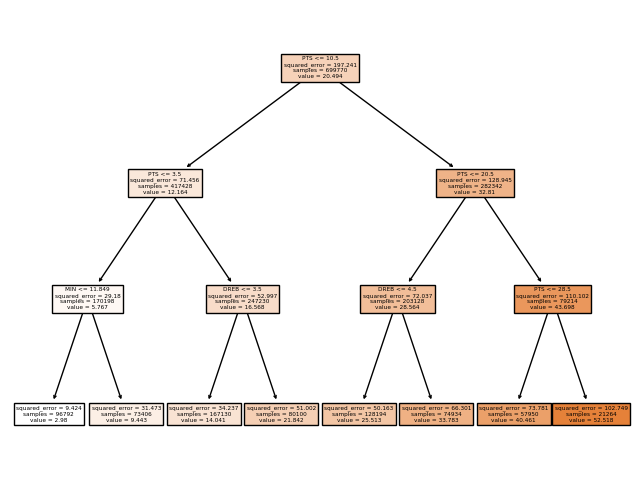

In [7]:
plt.figure(figsize=(8,6))
dtr = DecisionTreeRegressor(min_samples_split= 15, max_depth=3)
dtr.fit(df[features], df[target])
plot_tree(dtr, feature_names=dtr.feature_names_in_, filled=True)

<Figure size 1200x700 with 0 Axes>

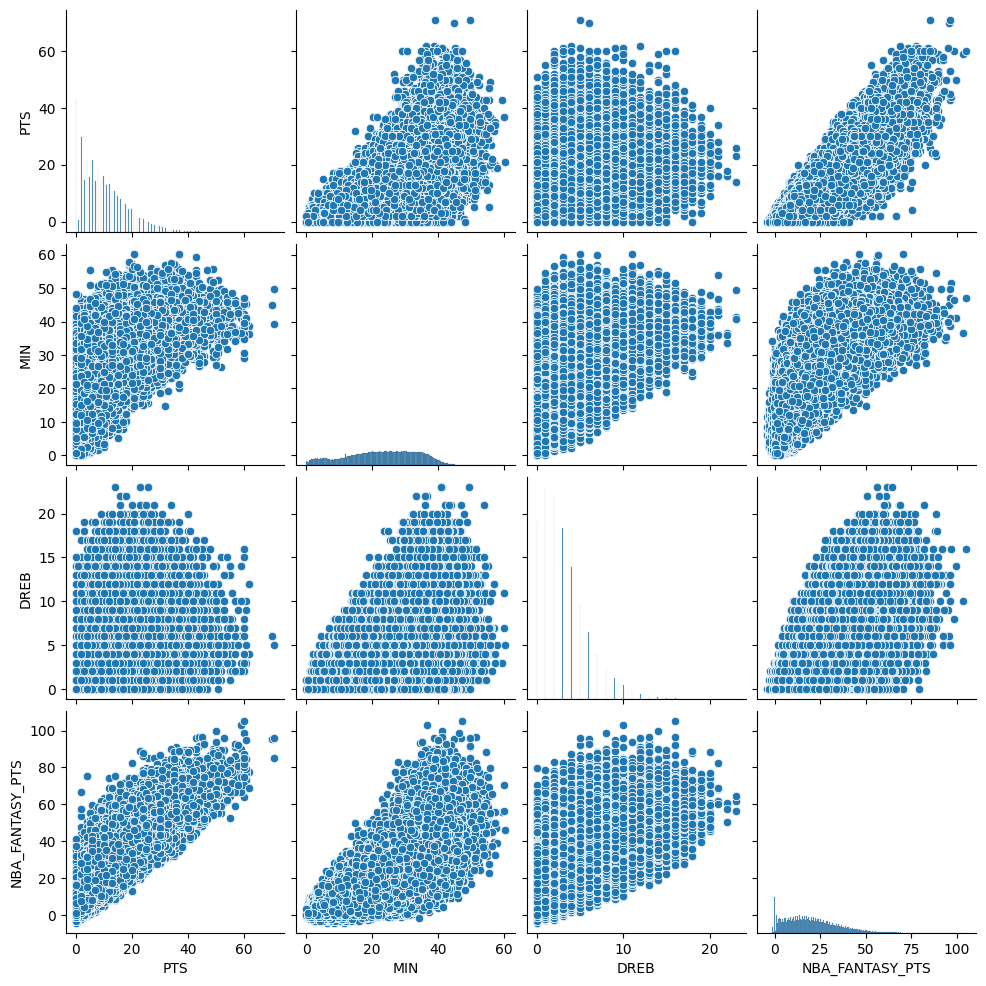

In [8]:
plt.figure(figsize=(12, 7))
sns.pairplot(df[['PTS', 'MIN', 'DREB', target]])

### Prediction
Looking at MSE for various modelsand look at predicted vs actual plot <br/>
to see if model predicts well - aka have a relationship between game stats and fantasy points

In [9]:
rfc = RandomForestRegressor(n_estimators=200, max_depth=16, n_jobs=4)
rfc.fit(X_train, y_train)
print("RFC: ", get_regression_metrics(rfc, X_valid, y_valid))

boosting_reg = GradientBoostingRegressor(n_estimators=200, min_samples_split=15)
boosting_reg.fit(X_train, y_train)
print("gradient boostingv2: ", get_regression_metrics(boosting_reg, X_valid, y_valid))

## PCA model
# scaler = StandardScaler()
# pca = PCA(n_components=4)
# pca_X_train = pca.fit_transform(scaler.fit_transform(X_train))
reg = ElasticNet(alpha=0.5, l1_ratio=0.25)
reg.fit(X_train, y_train)
print("elasticnet: ", get_regression_metrics(reg, X_valid, y_valid))

RFC:  {'rmse': 1.4337987373401528, 'mape': 17063967821671.574}
gradient boostingv2:  {'rmse': 1.806712082827566, 'mape': 17448892876152.443}
elasticnet:  {'rmse': 3.4456456468403576, 'mape': 17551361942961.002}


<Axes: title={'center': 'sklearn.ElasticNet'}, ylabel='NBA_FANTASY_PTS'>

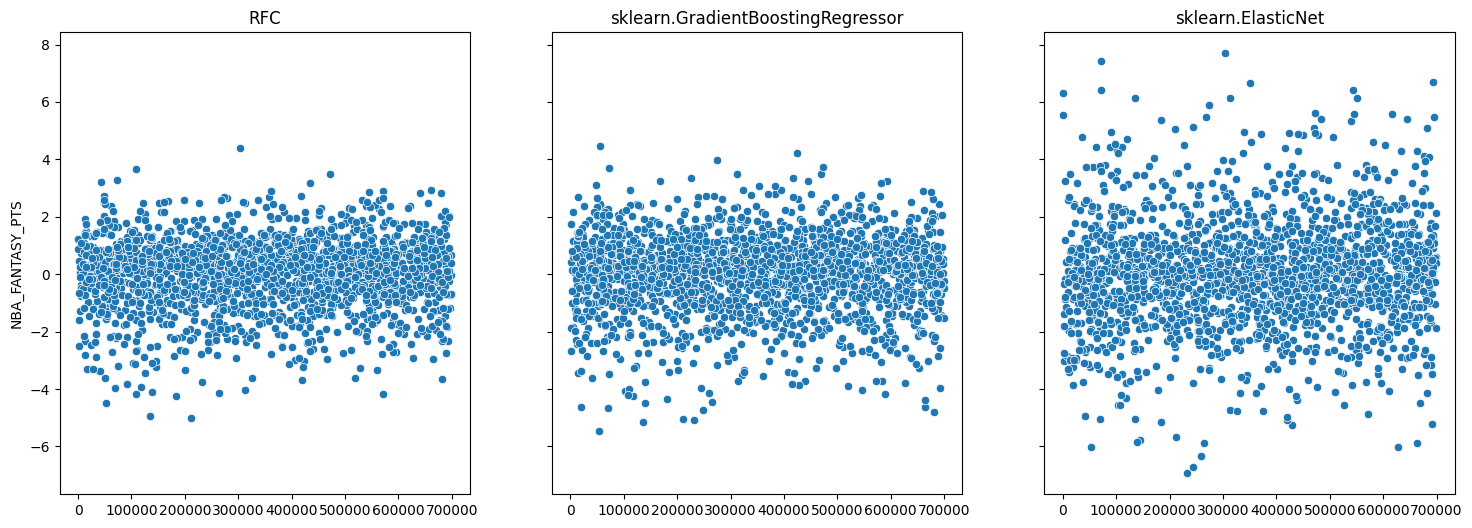

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.title.set_text("RFC")
sns.scatterplot(y_valid - rfc.predict(X_valid), ax=ax1)
ax2.title.set_text("sklearn.GradientBoostingRegressor")
sns.scatterplot(y_valid - boosting_reg.predict(X_valid), ax=ax2)
ax3.title.set_text("sklearn.ElasticNet")
sns.scatterplot(y_valid - reg.predict(X_valid), ax=ax3)

<Axes: title={'center': 'sklearn.ElasticNet'}>

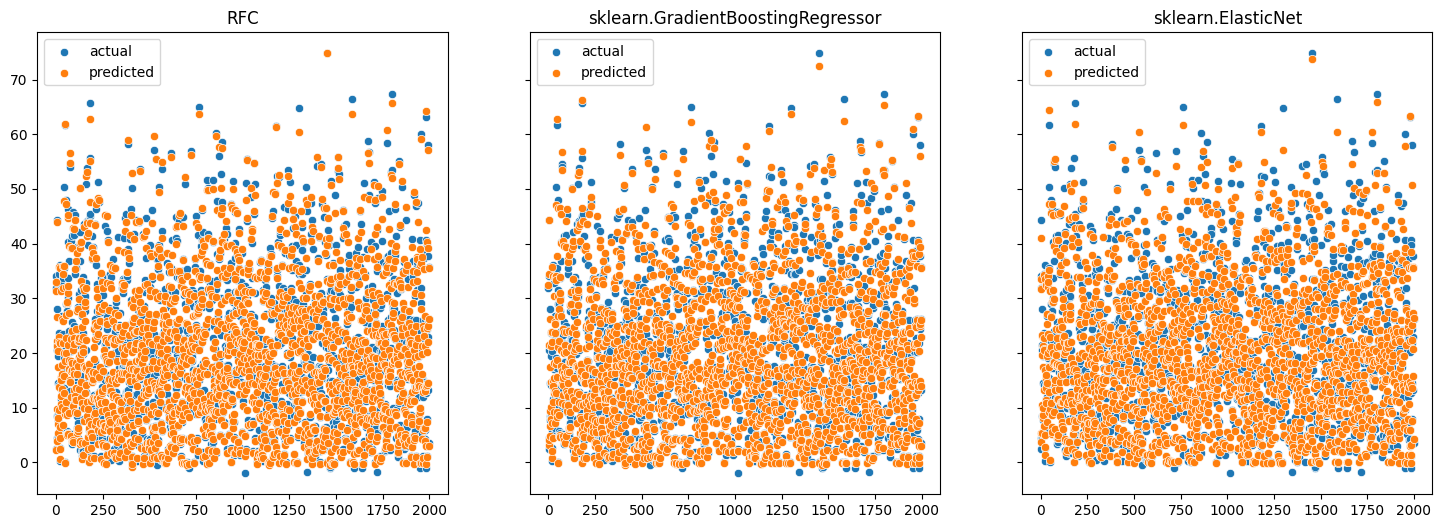

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.title.set_text("RFC")
sns.scatterplot(y_valid.values, ax=ax1, label="actual")
sns.scatterplot(rfc.predict(X_valid), ax=ax1, label="predicted")

ax2.title.set_text("sklearn.GradientBoostingRegressor")
sns.scatterplot(y_valid.values, ax=ax2, label="actual")
sns.scatterplot(boosting_reg.predict(X_valid), ax=ax2, label="predicted")
ax3.title.set_text("sklearn.ElasticNet")
sns.scatterplot(y_valid.values, ax=ax3, label="actual")
sns.scatterplot(reg.predict(X_valid), ax=ax3, label="predicted")